# Calculate 1D EM Distributions
Calculate the EM distributions for the various heating frequencies for (roughly) the grouping of pixels identified by Warren et al. (2012). Compare with the distribution derived from their reported intensities. Do this for all four heating frequencies plus ion case.

In [104]:
import os
import io
import copy
import glob
import urllib
from collections import OrderedDict

import numpy as np
import pandas
from scipy.optimize import curve_fit
import scipy.linalg
import scipy.stats
from scipy.interpolate import interp1d,splev,splrep
from scipy.ndimage import map_coordinates,gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.ticker import LogFormatter
import seaborn as sns
import astropy.units as u
import astropy.constants as const
import hissw
from sunpy.map import Map,GenericMap
import h5py
import ChiantiPy.tools.util as ch_util

import synthesizAR
from synthesizAR.instruments import InstrumentHinodeEIS
from synthesizAR.util import EISCube,EMCube
from synthesizAR.atomic import EmissionModel

sns.set_palette('deep')
sns.set_context(context='talk')

%matplotlib inline

In [217]:
frequencies = [250,
               750,
               '750-ion',
               2500,
               5000]

In [8]:
eis = InstrumentHinodeEIS([7.5e3,1.25e4]*u.s)

In [14]:
left_x = 350*u.arcsec
bottom_y = 265*u.arcsec
width = 20*u.arcsec
height = 15*u.arcsec
right_x = left_x + width
top_y = bottom_y + height

## Atomic Data

In [2]:
emission_model = EmissionModel.restore('/data/datadrive1/ar_forward_modeling/systematic_ar_study/emission_model1109_full/')

H I psplups file not found
He II psplups file not found
N VII psplups file not found
O VIII psplups file not found
Ne X psplups file not found
Na XI psplups file not found
Mg XII psplups file not found
Al XIII psplups file not found
Si XIV psplups file not found
P XV psplups file not found
S XVI psplups file not found
Cl XVII psplups file not found
Ar XVIII psplups file not found
K XIX psplups file not found
Ca XX psplups file not found
Fe XXVI psplups file not found
Ni XXVIII psplups file not found
He I psplups file not found
C V psplups file not found
N VI psplups file not found
O VII psplups file not found
Ne IX psplups file not found
Na X psplups file not found
Mg XI psplups file not found
Al XII psplups file not found
Si XIII psplups file not found
P XIV psplups file not found
S XV psplups file not found
Cl XVI psplups file not found
Ar XVII psplups file not found
K XVIII psplups file not found
Ca XIX psplups file not found
Fe XXV psplups file not found
Ni XXVII psplups file not f

In [3]:
resolved_wavelengths = np.sort(u.Quantity([rw for ion in emission_model.ions for rw in ion.resolved_wavelengths]))

In [120]:
pressure_const = 1e15*u.K*u.cm**(-3)
class FakeLoop(object):
    electron_temperature = np.logspace(5.1,7.1,100)*u.K
    density = pressure_const/electron_temperature
    
fake_loop = FakeLoop()
i_temperature,i_density = emission_model.interpolate_to_mesh_indices(fake_loop)

In [121]:
contribution_functions = {}
line_names = {}
for ion in emission_model.ions:
    for rw in ion.resolved_wavelengths:
        i_rw = np.where(ion.wavelength==rw)[0][0]
        emiss = map_coordinates(ion.emissivity[:,:,i_rw].value,
                                np.vstack([i_temperature,i_density]),order=3)*ion.emissivity.unit
        ioneq = splev(fake_loop.electron_temperature.value,
                      splrep(emission_model.temperature_mesh[:,0].value,
                             ion.fractional_ionization[:,0].value,k=1),ext=1)
        line_names[rw] = '{} {}'.format(ion.chianti_ion.meta['name'],rw.value)
        contribution_functions[rw] = (1./(np.pi*4.*u.steradian)*0.83
                                           *ioneq*ion.chianti_ion.abundance*emiss/fake_loop.density
                                           *(const.h.cgs*const.c.cgs)/rw.to(u.cm)/u.photon)

In [122]:
resolved_els = list(set([li[1].split(' ')[0].split('_')[0] for li in line_names.items()]))

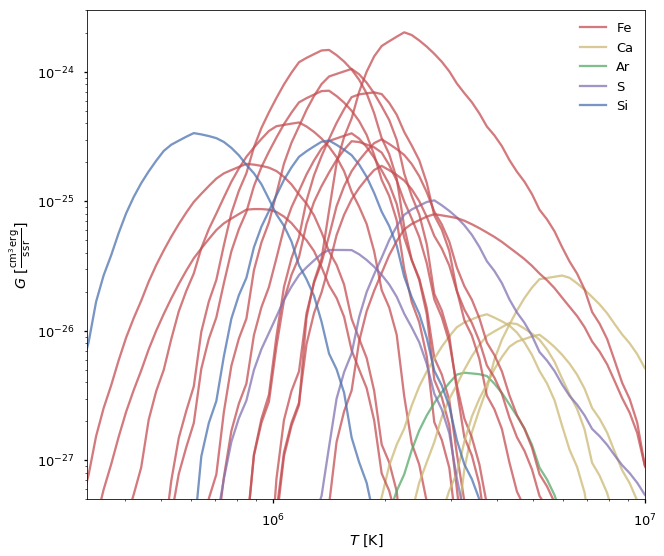

In [126]:
el_colors = {el:sns.color_palette('deep')[i] for i,el in enumerate(resolved_els)}
fig = plt.figure(figsize=(10,9))
ax = fig.gca()
for i,rw in enumerate(resolved_wavelengths):
    el = line_names[rw].split('_')[0]
    spec = ch_util.zion2spectroscopic(ch_util.el2z(el),int(line_names[rw].split('_')[1].split(' ')[0]))
    ax.plot(fake_loop.electron_temperature,contribution_functions[rw],alpha=0.75,
            color=el_colors[el],
            #label='{} {:.2f} $\mathrm{{\mathring{{A}}}}$'.format(spec,float(line_names[rw].split(' ')[1]))
            label=spec.split(' ')[0]
           )

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([5e-28,3e-24])
ax.set_xlim([10.**(5.5),10.**(7.)])
ax.set_xlabel(r'$T$ [{:latex}]'.format(fake_loop.electron_temperature.unit))
ax.set_ylabel(r'$G$ [{:latex}]'.format(contribution_functions[rw][1].unit))
hand,lab = ax.get_legend_handles_labels()
hand_lab = OrderedDict(zip(lab,hand))
ax.legend(hand_lab.values(),hand_lab.keys(),loc=1,ncol=1,frameon=False)
fig.savefig('../loops-workshop-2017-talk/template/img/contribution_fns.png',dpi=200,bbox_inches='tight')

## Data from Warren et al. (2012)

In [15]:
tmp = (urllib.request.urlopen('http://iopscience.iop.org/0004-637X/759/2/141/suppdata/apj446760t2_mrt.txt')
                     .readlines())
col_names = [str(t.strip()).split('  ')[-1] for t in tmp[8:15]]
col_names = [c[:-1] for c in col_names[0:2]] + ['Element','Ion','Wavelength'] + [c[:-1] for c in col_names[3:]]
table_io = io.StringIO(','.join(col_names) + '\n' 
                       + '\n'.join([','.join(filter(None,t.strip().decode('utf8').split(' '))) for t in tmp[19:]]))
df = pandas.read_csv(table_io)
df = df[df['Active region']==9]
df = df[df['Instrument (1)']=='EIS']
df = df.sort('Wavelength')

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [16]:
df

,Active region,Instrument (1),Element,Ion,Wavelength,Observed intensity,Error in OInt,Differential emission measure intensity,Ratio of OInt to DInt
172,9,EIS,Fe,XI,180.401,749.76,165.15,891.80,0.84
171,9,EIS,Fe,X,184.536,210.65,46.40,168.10,1.25
173,9,EIS,Fe,XI,188.216,467.97,102.97,443.68,1.05
169,9,EIS,Fe,IX,188.497,46.43,10.26,46.55,1.00
176,9,EIS,Fe,XII,192.394,386.91,85.13,340.03,1.14
189,9,EIS,Ca,XVII,192.858,120.88,26.67,113.19,1.07
186,9,EIS,Ca,XIV,193.874,308.59,67.90,254.06,1.21
185,9,EIS,Ar,XIV,194.396,72.31,15.92,75.10,0.96
177,9,EIS,Fe,XII,195.119,1236.18,271.97,1060.09,1.17
170,9,EIS,Fe,IX,197.862,29.40,6.49,29.01,1.01


## Integrate Intensities

In [295]:
line_intensities = {'{}'.format(freq):{} for freq in frequencies}

In [296]:
for freq in frequencies:
    for channel in eis.channels:
        tmp = EISCube('../data/eis_intensity_{}_tn{}_t7500-12500.h5'.format(channel['name'],freq))
        if type(freq) == int:
            tmp.data = (gaussian_filter(tmp.data.value,(channel['gaussian_width']['y'].value,
                                                        channel['gaussian_width']['x'].value,0.)))*tmp.data.unit
        for rw in resolved_wavelengths:
            i_center = np.where(np.isclose(tmp.wavelength.value,rw.value,atol=1.1e-2,rtol=0.))[0]
            if len(i_center) == 0:
                continue
            line_intensities['{}'.format(freq)][rw] = tmp[i_center-5:i_center+5].integrated_intensity

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/astropy/units/quantity.py:1023: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  out = super(Quantity, self).__getitem__(key)


## EIS Result with Labeled ROI

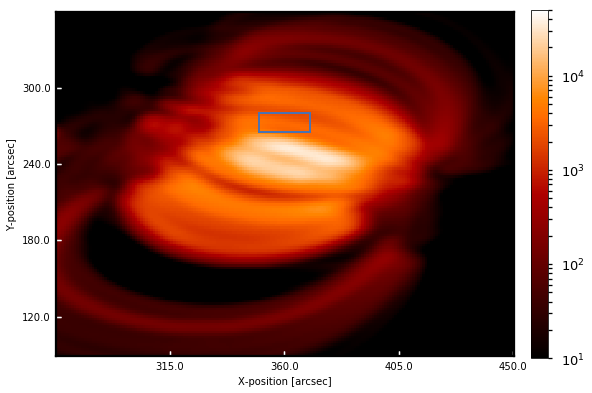

In [372]:
eis_fexii_map = (line_intensities['250'][resolved_wavelengths[8]]
                 .submap(u.Quantity((270,450),u.arcsec),u.Quantity((90,360),u.arcsec)))
fig = plt.figure(figsize=(8,8))
plt.subplots_adjust(right=0.92)
cax = fig.add_axes([0.95,0.2,0.03,0.605])
ax = fig.add_subplot(111,projection=eis_fexii_map)
im = eis_fexii_map.plot(norm=matplotlib.colors.SymLogNorm(1,vmin=10,vmax=5e4),title=False)
ax.coords[0].grid(alpha=0)
ax.coords[1].grid(alpha=0)
ax.coords[0].set_ticks(size=5)
ax.coords[1].set_ticks(size=5)
eis_fexii_map.draw_rectangle(u.Quantity((left_x,bottom_y)),width,height,color=sns.color_palette()[0],lw=2)
fig.colorbar(im,ax=ax,cax=cax)
fig.savefig('../loops-workshop-2017-talk/template/img/eis_fe12_roi.png',dpi=200,bbox_inches='tight')

## Ground-truth EM Results

In [220]:
ground_truth_em ={}
for freq in frequencies:
    ground_truth_em['{}'.format(freq)] = EMCube.restore('../data/em_cubes_true_tn{}_t7500-12500.h5'.format(freq))

## Regularized Inversion Code

In [221]:
class DEM1DResults(object):
    
    def __init__(self,dem_results):
        self.temperature_bins = np.float64(dem_results['temperature_bins'])
        self.temperature_bin_centers = (self.temperature_bins[:-1] + self.temperature_bins[1:])/2.
        self.temperature_error_plus = self.temperature_bin_centers*(10.**(dem_results['elogt']) - 1.)
        self.temperature_error_minus = self.temperature_bin_centers*(1. - 10.**(-dem_results['elogt']))
        self.dem = dem_results['dem']
        self.em = dem_results['dem']*np.diff(self.temperature_bins)
        self.dem_errors = dem_results['edem']
        self.em_errors = np.diff(self.temperature_bins)*dem_results['edem']
        self.chi_squared = dem_results['chisq']
        self.regularized_data = dem_results['dn_reg']

In [222]:
static_input_vars = {
                     'log_temperature':np.log10(fake_loop.electron_temperature.value).tolist(),
                     'temperature_bins':ground_truth_em['250'].temperature_bin_edges.value.tolist(),
                     'k_matrix':[contribution_functions[rw].value.tolist() for rw in resolved_wavelengths],
                     'names':['{} {}'.format(rw.value,rw.unit) for rw in resolved_wavelengths],
                     'error_ratio':0.25,
                     'gloci':1,'reg_tweak':1,'timed':1
                    }
save_vars = ['dem','edem','elogt','chisq','dn_reg','temperature_bins']
demreg_script = """
; load intensity from each channel/line
names = {{ names }}
intensity = {{ intensity }}
; load the contribution functions or response functions (called K in Hannah and Kontar 2012)
k_matrix = {{ k_matrix }}
; load temperature array over which K is computed
log_temperature = {{ log_temperature }}

; temperature bins
temperature_bins = {{ temperature_bins }}

; crude estimate of intensity errors
intensity_errors = intensity*{{ error_ratio }}

; inversion method parameters
reg_tweak={{ reg_tweak }}
timed={{ timed }}
gloci={{ gloci }}

; run the inversion method
dn2dem_pos_nb,intensity,intensity_errors,$
              k_matrix,log_temperature,temperature_bins,$
              dem,edem,elogt,chisq,dn_reg,$
              timed=timed,gloci=gloci,reg_tweak=reg_tweak
"""
demreg_runner = hissw.ScriptMaker(extra_paths=['/home/wtb2/Documents/codes/demreg/idl/'],
                                  ssw_path_list=['vobs','ontology'])

### Simulated Results

In [223]:
demreg_simulate = {}
for freq in frequencies:
    input_vars = static_input_vars.copy()
    input_vars['intensity'] = [line_intensities['{}'.format(freq)][rw].submap(u.Quantity((left_x,right_x)),
                                                                              u.Quantity((bottom_y,top_y))).data.mean() 
                               for rw in resolved_wavelengths]
    demreg_simulate['{}'.format(freq)] = DEM1DResults(demreg_runner.run([(demreg_script,input_vars)],
                                                             save_vars=save_vars,
                                                             cleanup=True,verbose=True))

SSW  setup will include: <gen>

Type <sswidl> to start SSW IDL
--------------------------------------------------------
Running SSW, Last Updated: Wed Nov 2 22:22:51 GMT 2005
 
PROBLEMS? - e-mail TO: freeland@penumbra.nascom.nasa.gov
--------------------------------------------------------
IDL Version 8.5 (linux x86_64 m64). (c) 2015, Exelis Visual Information Solutions, Inc., a subsidiary of Harris Corporation.
Installation number: 401801-1.
Licensed for use by: Rice University

Executing SSW IDL_STARTUP for: GEN
Executing SSW IDL_STARTUP for: SITE
% Compiled module: SSW_PATH.
% Compiled module: SSW_INSTRUMENTS.
% Compiled module: WC_WHERE.
% Compiled module: PATHFIX.
% Compiled module: UNIQO.
% Compiled module: STRJUSTIFY.
% Compiled module: UNIQ.
% Compiled module: DEFAULT.
% Compiled module: PRSTR.
Including Paths:
 ---------------------------------
| $SSW/vobs/gen/idl               |
| $SSW/vobs/ontology/idl/jsoc     |
| $SSW/vobs/ontology/idl/gen_temp |
| $SSW/vobs/ontology/idl  

### Observational Data

In [131]:
input_vars = static_input_vars.copy()
input_vars['intensity'] = [float(df['Observed intensity'][df['Wavelength'].apply(np.isclose, b=rw.value, atol=2e-2)])
                           for rw in resolved_wavelengths]
dem_output_warren = DEM1DResults(demreg_runner.run([(demreg_script,input_vars)],
                                                     save_vars=save_vars,
                                                     cleanup=True,verbose=True))

SSW  setup will include: <gen>

Type <sswidl> to start SSW IDL
--------------------------------------------------------
Running SSW, Last Updated: Wed Nov 2 22:22:51 GMT 2005
 
PROBLEMS? - e-mail TO: freeland@penumbra.nascom.nasa.gov
--------------------------------------------------------
IDL Version 8.5 (linux x86_64 m64). (c) 2015, Exelis Visual Information Solutions, Inc., a subsidiary of Harris Corporation.
Installation number: 401801-1.
Licensed for use by: Rice University

Executing SSW IDL_STARTUP for: GEN
Executing SSW IDL_STARTUP for: SITE
% Compiled module: SSW_PATH.
% Compiled module: SSW_INSTRUMENTS.
% Compiled module: WC_WHERE.
% Compiled module: PATHFIX.
% Compiled module: UNIQO.
% Compiled module: STRJUSTIFY.
% Compiled module: UNIQ.
% Compiled module: DEFAULT.
% Compiled module: PRSTR.
Including Paths:
 ---------------------------------
| $SSW/vobs/gen/idl               |
| $SSW/vobs/ontology/idl/jsoc     |
| $SSW/vobs/ontology/idl/gen_temp |
| $SSW/vobs/ontology/idl  

## Compare
Compare the observed 1D distribution, results from regularized code, and "ground truth" EM.

In [132]:
def linear_fit(x,a,b):
        return a*x + b

[ 5.2527212]


/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/ipykernel/__main__.py:38: RuntimeWarning: divide by zero encountered in true_divide


[ 3.23423688]
[ 3.39197169]
[ 3.5393672]


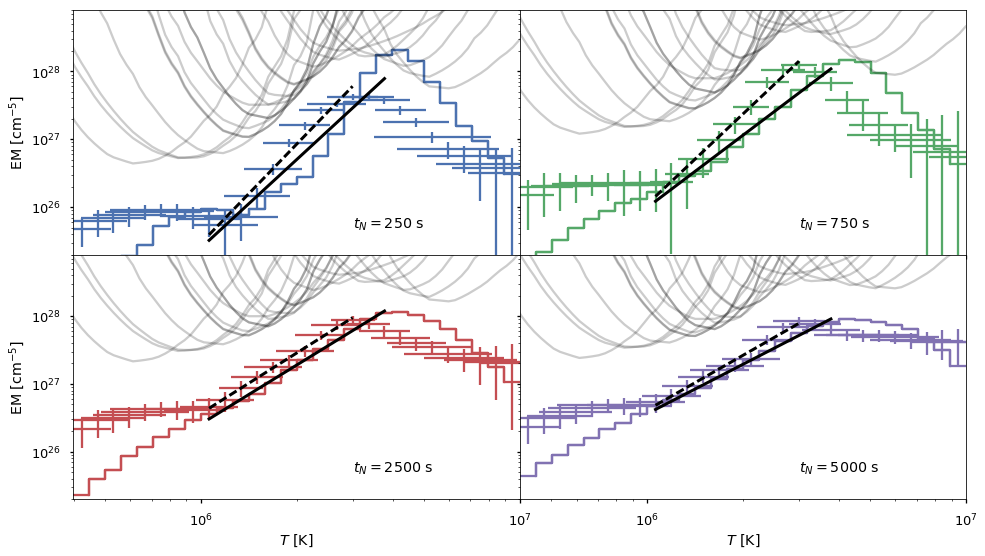

In [265]:
fig,axes = plt.subplots(2,2,figsize=(16,9),sharex=True,sharey=True)
plt.subplots_adjust(wspace=0,hspace=0)
for ax,(i,freq) in zip(axes.flatten(),enumerate([250,750,2500,5000])):
    #### Ground Truth ####
    # make 1d selection from boxed region
    temperature_bin_edges,em = ground_truth_em['{}'.format(freq)].get_1d_distribution(u.Quantity((left_x,right_x)),
                                                                                      u.Quantity((bottom_y,top_y)))
    # compute slope
    t_bin_centers = (temperature_bin_edges[1:] + temperature_bin_edges[:-1])/2.
    i_fit = np.where(np.logical_and(t_bin_centers>=1e6*u.K,
                                    t_bin_centers<=4e6*u.K))
    t_fit = t_bin_centers[i_fit].value
    em_fit = em[i_fit].value
    popt,pcov = curve_fit(linear_fit,np.log10(t_fit),np.log10(em_fit))
    # plot
    ax.step(temperature_bin_edges[:-1],em,where='post',
            color=sns.color_palette('deep')[i],label=r'$t_N={}$ s, $a={:.2f}$'.format(freq,popt[0]))
    ax.step(temperature_bin_edges[1:],em,where='pre',
            color=sns.color_palette()[i])
    ax.plot(t_fit,10.**linear_fit(np.log10(t_fit),*popt),c='k',lw=3,ls='-',alpha=1.0)
    #### Regularized DEM ####
    i_fit = np.where(np.logical_and(demreg_simulate['{}'.format(freq)].temperature_bin_centers>=1e6,
                                    demreg_simulate['{}'.format(freq)].temperature_bin_centers<=3e6))
    t_fit = demreg_simulate['{}'.format(freq)].temperature_bin_centers[i_fit]
    em_fit = demreg_simulate['{}'.format(freq)].em[i_fit]
    popt,pcov = curve_fit(linear_fit,np.log10(t_fit),np.log10(em_fit))
    ax.errorbar(demreg_simulate['{}'.format(freq)].temperature_bin_centers,
                demreg_simulate['{}'.format(freq)].em,
                yerr=demreg_simulate['{}'.format(freq)].em_errors,
                xerr=[demreg_simulate['{}'.format(freq)].temperature_error_minus,
                      demreg_simulate['{}'.format(freq)].temperature_error_plus],
                ls='',marker='',color=sns.color_palette()[i])
    ax.plot(t_fit,10.**linear_fit(np.log10(t_fit),*popt),c='k',lw=3,ls='--',alpha=1.0)
    print(demreg_simulate['{}'.format(freq)].chi_squared)
    # em loci curves
    for j,rw in enumerate(resolved_wavelengths):
        ax.plot(fake_loop.electron_temperature,
                demreg_simulate['{}'.format(freq)].regularized_data[j]/contribution_functions[rw],
                color='k',alpha=0.2)
    # frequency label
    ax.text(3e6,5e25,r'$t_N={}$ s'.format(freq),fontsize=matplotlib.rcParams['axes.labelsize'])

axes[0,0].set_xscale('log')
axes[0,0].set_yscale('log')
axes[0,0].set_xlim([temperature_bin_edges[0].value,temperature_bin_edges[-1].value])
axes[0,0].set_ylim([2e25,8e28])
axes[1,0].set_xlabel(r'$T$ [K]')
axes[1,1].set_xlabel(r'$T$ [K]')
axes[0,0].set_ylabel(r'$\mathrm{EM}$ [cm$^{-5}$]')
axes[1,0].set_ylabel(r'$\mathrm{EM}$ [cm$^{-5}$]')
fig.savefig('../loops-workshop-2017-talk/template/img/em_true_predict_4panel.png',
            dpi=200,bbox_inches='tight')

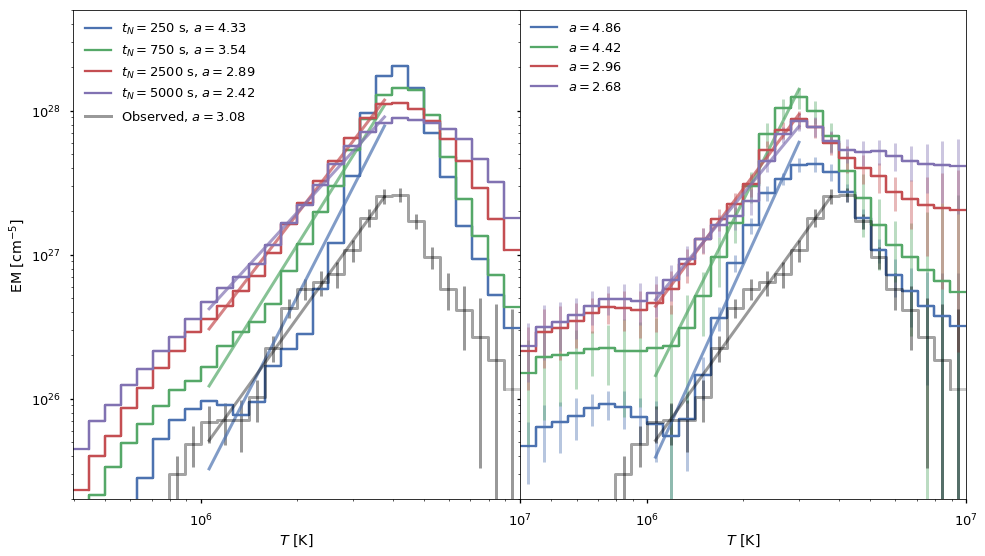

In [340]:
fig,axes = plt.subplots(1,2,figsize=(16,9),sharex=True,sharey=True)
plt.subplots_adjust(wspace=0,hspace=0)
for i,freq in enumerate([250,750,2500,5000]):
    #### Ground Truth ####
    # make 1d selection from boxed region
    temperature_bin_edges,em = ground_truth_em['{}'.format(freq)].get_1d_distribution(u.Quantity((left_x,right_x)),
                                                                                      u.Quantity((bottom_y,top_y)))
    # compute slope
    t_bin_centers = (temperature_bin_edges[1:] + temperature_bin_edges[:-1])/2.
    i_fit = np.where(np.logical_and(t_bin_centers>=1e6*u.K,
                                    t_bin_centers<=4e6*u.K))
    t_fit = t_bin_centers[i_fit].value
    em_fit = em[i_fit].value
    popt,pcov = curve_fit(linear_fit,np.log10(t_fit),np.log10(em_fit))
    # plot
    axes[0].step(temperature_bin_edges[:-1],em,where='post',
                 color=sns.color_palette()[i],
                 label=r'$t_N={}$ s, $a={:.2f}$'.format(freq,popt[0]))
    axes[0].step(temperature_bin_edges[1:],em,where='pre',
            color=sns.color_palette()[i])
    axes[0].plot(t_fit,10.**linear_fit(np.log10(t_fit),*popt),c=sns.color_palette()[i],lw=3,ls='-',alpha=0.7)
    
    #### Regularized DEM ####
    # compute slope
    i_fit = np.where(np.logical_and(demreg_simulate['{}'.format(freq)].temperature_bin_centers>=1e6,
                                    demreg_simulate['{}'.format(freq)].temperature_bin_centers<=3e6))
    t_fit = demreg_simulate['{}'.format(freq)].temperature_bin_centers[i_fit]
    em_fit = demreg_simulate['{}'.format(freq)].em[i_fit]
    em_fit_errors = demreg_simulate['{}'.format(freq)].em_errors[i_fit]
    popt,pcov = curve_fit(linear_fit,np.log10(t_fit),np.log10(em_fit),
                          sigma=np.log10(em_fit_errors),
                          #absolute_sigma=True
                         )
    # plot
    axes[1].plot(t_fit,10.**linear_fit(np.log10(t_fit),*popt),c=sns.color_palette()[i],lw=3,ls='-',alpha=0.7)
    axes[1].step(demreg_simulate['{}'.format(freq)].temperature_bins[:-1],
                   demreg_simulate['{}'.format(freq)].em,where='post',
                   color=sns.color_palette()[i],
                   label=r'$a={:.2f}$'.format(popt[0]))
    axes[1].step(demreg_simulate['{}'.format(freq)].temperature_bins[1:],
                   demreg_simulate['{}'.format(freq)].em,where='pre',
                   color=sns.color_palette()[i])
    axes[1].errorbar(demreg_simulate['{}'.format(freq)].temperature_bin_centers,
                     demreg_simulate['{}'.format(freq)].em,
                     yerr=demreg_simulate['{}'.format(freq)].em_errors,
                     ls='',marker='',color=sns.color_palette()[i],alpha=0.4,lw=3)
    
#### Warren et al 2012 data ####
# compute slope
i_fit = np.where(np.logical_and(dem_output_warren.temperature_bin_centers>=1e6,
                                dem_output_warren.temperature_bin_centers<=4e6))
t_fit = dem_output_warren.temperature_bin_centers[i_fit]
em_fit = dem_output_warren.em[i_fit]
popt,pcov = curve_fit(linear_fit,np.log10(t_fit),np.log10(em_fit),
                      #absolute_sigma=True,
                      sigma=np.log10(dem_output_warren.em_errors[i_fit])
                     )
axes[0].plot(t_fit,10.**linear_fit(np.log10(t_fit),*popt),c='k',lw=3,ls='-',alpha=0.4,
             label=r'Observed, $a={:.2f}$'.format(popt[0]))
axes[1].plot(t_fit,10.**linear_fit(np.log10(t_fit),*popt),c='k',lw=3,ls='-',alpha=0.4)
axes[0].errorbar(dem_output_warren.temperature_bin_centers,dem_output_warren.em,
            yerr=dem_output_warren.em_errors,
            ls='',marker='',color='k',alpha=0.4,lw=3)
axes[1].errorbar(dem_output_warren.temperature_bin_centers,dem_output_warren.em,
            yerr=dem_output_warren.em_errors,
            ls='',marker='',color='k',alpha=0.4,lw=3)
axes[0].step(dem_output_warren.temperature_bins[:-1],
               dem_output_warren.em,where='post',
               color='k',lw=3,alpha=0.2)
axes[0].step(dem_output_warren.temperature_bins[1:],
               dem_output_warren.em,where='pre',
               color='k',lw=3,alpha=0.2)
axes[1].step(dem_output_warren.temperature_bins[:-1],
               dem_output_warren.em,where='post',
               color='k',lw=3,alpha=0.2)
axes[1].step(dem_output_warren.temperature_bins[1:],
               dem_output_warren.em,where='pre',
               color='k',lw=3,alpha=0.2)

axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlim([temperature_bin_edges[0].value,temperature_bin_edges[-1].value])
axes[0].set_ylim([2e25,5e28])
axes[0].legend(loc=2,frameon=False)
axes[1].legend(loc=2,frameon=False)
axes[0].set_xlabel(r'$T$ [K]')
axes[1].set_xlabel(r'$T$ [K]')
axes[0].set_ylabel(r'$\mathrm{EM}$ [cm$^{-5}$]')
fig.savefig('../loops-workshop-2017-talk/template/img/em_true_predict_2panel.png',
            dpi=200,bbox_inches='tight')

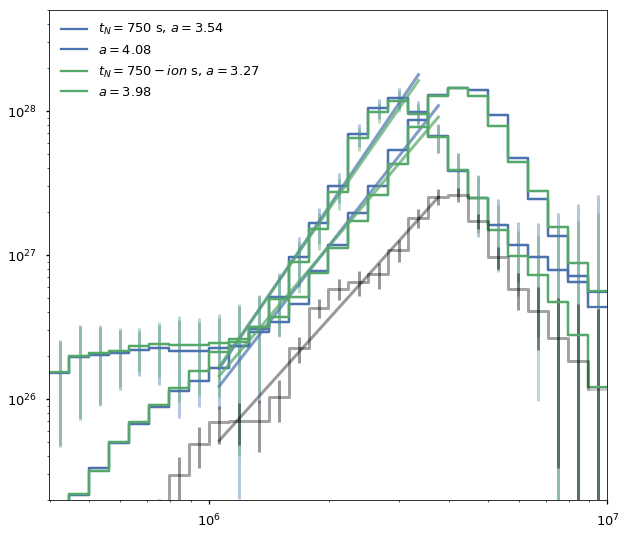

In [228]:
fig = plt.figure(figsize=(10,9))
ax = fig.gca()
for i,freq in enumerate([750,'750-ion']):
    #### Ground Truth ####
    # make 1d selection from boxed region
    temperature_bin_edges,em = ground_truth_em['{}'.format(freq)].get_1d_distribution(u.Quantity((left_x,right_x)),
                                                                                      u.Quantity((bottom_y,top_y)))
    # compute slope
    t_bin_centers = (temperature_bin_edges[1:] + temperature_bin_edges[:-1])/2.
    i_fit = np.where(np.logical_and(t_bin_centers>=1e6*u.K,
                                    t_bin_centers<=4e6*u.K))
    t_fit = t_bin_centers[i_fit].value
    em_fit = em[i_fit].value
    popt,pcov = curve_fit(linear_fit,np.log10(t_fit),np.log10(em_fit))
    # plot
    ax.step(temperature_bin_edges[:-1],em,where='post',
                 color=sns.color_palette()[i],
                 label=r'$t_N={}$ s, $a={:.2f}$'.format(freq,popt[0]))
    ax.step(temperature_bin_edges[1:],em,where='pre',
            color=sns.color_palette()[i])
    ax.plot(t_fit,10.**linear_fit(np.log10(t_fit),*popt),c=sns.color_palette()[i],lw=3,ls='-',alpha=0.7)

    #### Regularized DEM ####
    # compute slope
    i_fit = np.where(np.logical_and(demreg_simulate['{}'.format(freq)].temperature_bin_centers>=1e6,
                                    demreg_simulate['{}'.format(freq)].temperature_bin_centers<=3.5e6))
    t_fit = demreg_simulate['{}'.format(freq)].temperature_bin_centers[i_fit]
    em_fit = demreg_simulate['{}'.format(freq)].em[i_fit]
    popt,pcov = curve_fit(linear_fit,np.log10(t_fit),np.log10(em_fit))
    # plot
    ax.plot(t_fit,10.**linear_fit(np.log10(t_fit),*popt),c=sns.color_palette()[i],lw=3,ls='-',alpha=0.7)
    ax.step(demreg_simulate['{}'.format(freq)].temperature_bins[:-1],
                   demreg_simulate['{}'.format(freq)].em,where='post',
                   color=sns.color_palette()[i],
                   label=r'$a={:.2f}$'.format(popt[0]))
    ax.step(demreg_simulate['{}'.format(freq)].temperature_bins[1:],
                   demreg_simulate['{}'.format(freq)].em,where='pre',
                   color=sns.color_palette()[i])
    ax.errorbar(demreg_simulate['{}'.format(freq)].temperature_bin_centers,
                     demreg_simulate['{}'.format(freq)].em,
                     yerr=demreg_simulate['{}'.format(freq)].em_errors,
                     ls='',marker='',color=sns.color_palette()[i],alpha=0.4,lw=3)
    
#### Warren et al 2012 data ####
# compute slope
i_fit = np.where(np.logical_and(dem_output_warren.temperature_bin_centers>=1e6,
                                dem_output_warren.temperature_bin_centers<=4e6))
t_fit = dem_output_warren.temperature_bin_centers[i_fit]
em_fit = dem_output_warren.em[i_fit]
popt,pcov = curve_fit(linear_fit,np.log10(t_fit),np.log10(em_fit))
ax.plot(t_fit,10.**linear_fit(np.log10(t_fit),*popt),c='k',lw=3,ls='-',alpha=0.4)
ax.errorbar(dem_output_warren.temperature_bin_centers,dem_output_warren.em,
            yerr=dem_output_warren.em_errors,
            ls='',marker='',color='k',alpha=0.4,lw=3)
ax.step(dem_output_warren.temperature_bins[:-1],
               dem_output_warren.em,where='post',
               color='k',lw=3,alpha=0.2)
ax.step(dem_output_warren.temperature_bins[1:],
               dem_output_warren.em,where='pre',
               color='k',lw=3,alpha=0.2)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([temperature_bin_edges[0].value,temperature_bin_edges[-1].value])
ax.set_ylim([2e25,5e28])
ax.legend(loc=2,frameon=False)
ax.legend(loc=2,frameon=False)